# RQ3
> can we predict the relationship between the frequency of tokens of a review and the polarity?
- independent: token frequency
- dependent: polarity (positive / negative)

In [2]:
# data processing
import pandas as pd
# import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# natural language processing
import nltk
nltk.data.path.append('/usr/share/nltk_data/')
from nltk import pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import string

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

# machine learning imports
from funcsigs import signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, average_precision_score, precision_recall_curve, roc_curve

# matplotlib things
plt.style.use('seaborn-v0_8-poster')

In [3]:
# import the data
df = pd.read_csv('./data/combined_sentiments.csv', header=0, sep=',', on_bad_lines='skip')

# lemmatise
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# check whether there is a digit or not
def check_digits(text):
     return any(i.isdigit() for i in text)

# tokenise
def clean_review(review):
	review = str(review)
	review = review.lower() # turn into lowercase
	review = [word.strip(string.punctuation) for word in review.split(' ')] # remove punctuation
	review = [word for word in review if not check_digits(word)] # remove digits

	# remove stop words
	stop = stopwords.words('english')
	review = [token for token in review if token not in stop]
	# remove empty tokens
	review = [token for token in review if len(token) > 0]
	
	# tag each token with its part of speech (pos)
	pos_tags = pos_tag(review)
	review = [WordNetLemmatizer().lemmatize(tag[0], get_wordnet_pos(tag[1])) for tag in pos_tags]

	# remove words with only one letter
	review = [token for token in review if len(token) > 1]
	review = ' '.join(review)
	return review

# generate a cleaned, tokenised and lemmatised version of the reviews
df['reviews.clean'] = df['reviews.text'].apply(lambda x: clean_review(x))

In [4]:
# extract vector representations for each review.
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(df["reviews.clean"].apply(lambda x: x.split(' ')))]

# train a doc2vec model
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into vec data
df_vec = df['reviews.clean'].apply(lambda x: model.infer_vector(x.split(' '))).apply(pd.Series)
df_vec.columns = ['vec_' + str(x) for x in df_vec.columns]
df = pd.concat([df, df_vec], axis=1)

In [5]:
# add the term frequency - inverse document frequency values for every word
tfidf = TfidfVectorizer(min_df=10)
tfidf_result = tfidf.fit_transform(df['reviews.clean']).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns=tfidf.get_feature_names_out())
tfidf_df.columns = ['word_' + str(x) for x in tfidf_df.columns]
tfidf_df.index = df.index
df = pd.concat([df, tfidf_df], axis=1)

In [6]:
# distribution of sentiments
# for polar in [-1, 1]: # positive or negative (don't consider neutrals)
plt.title('Distribution of Reviews by Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Number of Reviews')

subset_neg = df[df['sent.polarity'] == -1]
sns.histplot(subset_neg['sent.net'], label='negative', kde=True)

subset_pos = df[df['sent.polarity'] == 1]
sns.histplot(subset_pos['sent.net'], label='positive', kde=True)
plt.savefig("./results/rq3/distribution.png", dpi=1200, bbox_inches='tight')
plt.clf()

<Figure size 1280x880 with 0 Axes>

In [7]:
# is_bad: True if polarity == -1 else False
df['review.is_bad'] = df['sent.polarity'].apply(lambda x: x == -1)

# feature selection
label = 'review.is_bad'
ignore_cols = [label, "sent.polarity", "sent.pos", "sent.neg", "sent.net", "index", "reviews.rating", "reviews.clean", "reviews.title", "reviews.text"]
features = [col for col in df.columns if col not in ignore_cols]

# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(df[features], df[label], test_size=0.2, random_state=42)

In [8]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(x_train, y_train)

# show feature importance
feature_importances_df = pd.DataFrame({'feature': features, 'importance': rf.feature_importances_}).sort_values('importance', ascending=False)
# feature_importances_df.head(20)

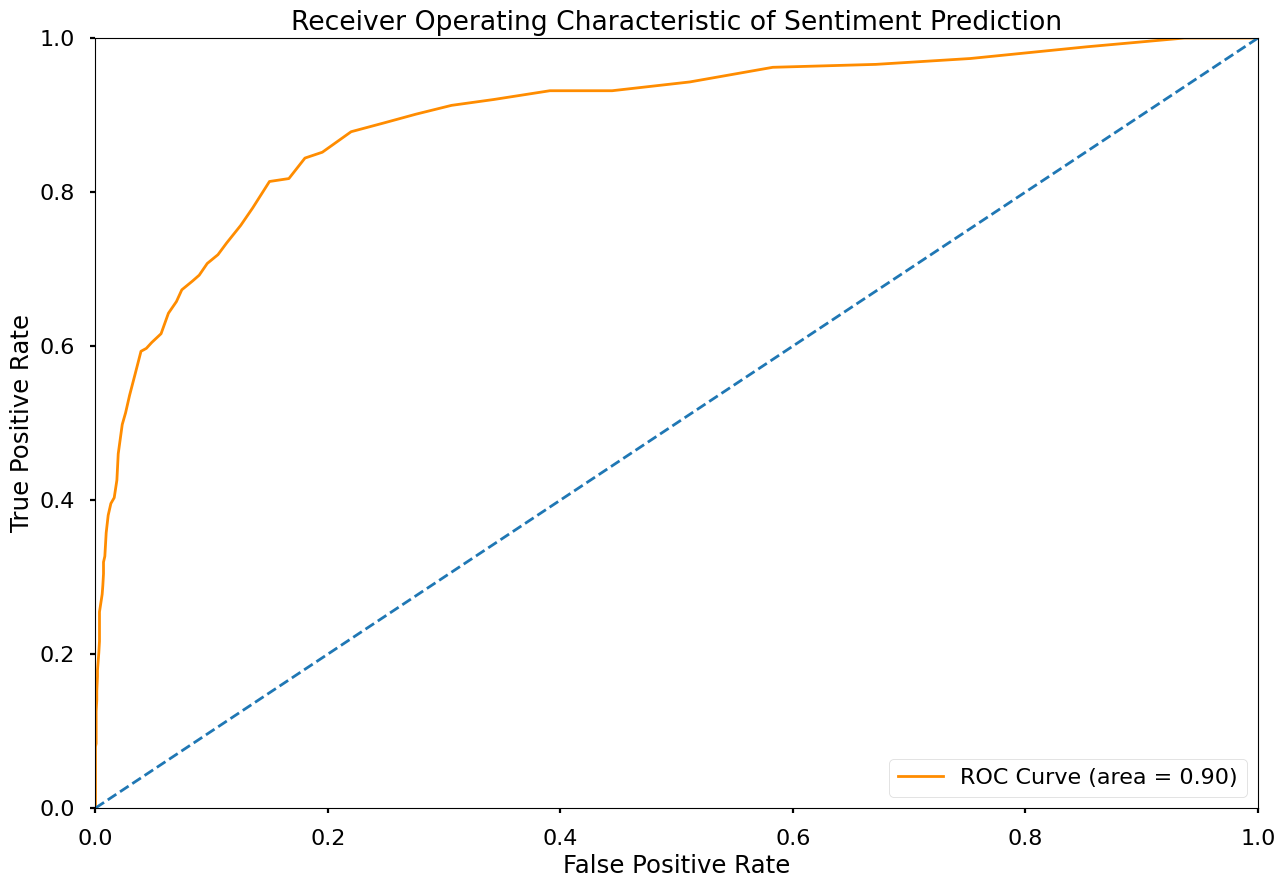

In [9]:
y_pred = [pred[1] for pred in rf.predict_proba(x_test)]
# false +ve rate, true +ve rate
fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)

'''
receiver operating characteristic:
the higher the curve above the diagonal baseline, the better the preds
'''
roc_auc = auc(fpr, tpr)

# plot the roc curve
plt.figure(1, figsize=(15, 10))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC Curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic of Sentiment Prediction')
plt.legend(loc="lower right")
plt.show()

Text(0.5, 1.0, '2-Class Precision-Recall Curve. Average Precision: 0.68')

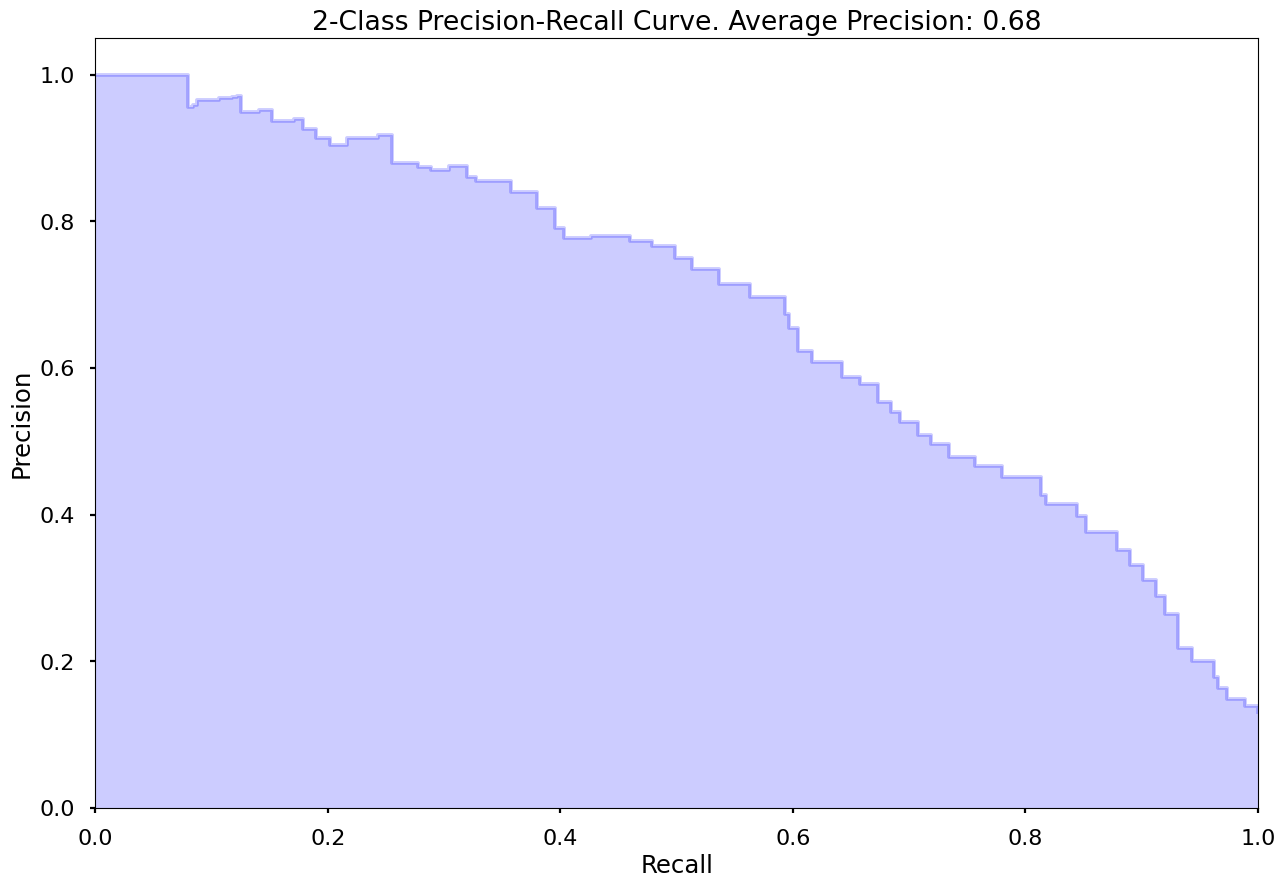

In [10]:
# area-under-curve precision-recall
average_precision = average_precision_score(y_test, y_pred)

precision, recall, _ = precision_recall_curve(y_test, y_pred)

step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})

plt.figure(1, figsize=(15, 10))
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-Class Precision-Recall Curve. Average Precision: {0:0.2f}'.format(average_precision))